In [1]:
%pip install transformers

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


## Download the Dataset

In [2]:
%pwd

'/notebooks'

In [3]:
import os
import wget

print(f"Downloading the dataset ...")

url = "https://nyu-mll.github.io/CoLA/cola_public_1.1.zip"
path = './cola_public_1.1.zip'
# download the file from the url
if not os.path.exists(path):
    wget.download(url, path)

In [4]:
%ls

Grammer_check_with_BERT.ipynb  cola_public_1.1.zip  quick_start_pytorch.ipynb
cola_public/                   instance_type.png


In [5]:
import zipfile

In [6]:
# Extract the dataset
if not os.path.exists('./cola_public'):
    with zipfile.ZipFile(path, 'r') as zip_file:
        zip_file.extractall('./cola_public')

In [7]:
%ls

Grammer_check_with_BERT.ipynb  cola_public_1.1.zip  quick_start_pytorch.ipynb
cola_public/                   instance_type.png


In [8]:
%pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd
import numpy as np

import warnings
import time

import torch.nn as nn
import torch
from torch.utils.data import DataLoader
import torch.optim as optim

import transformers
from transformers import BertTokenizer, BertModel
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn import model_selection, metrics

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
warnings.filterwarnings("ignore")

In [10]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

In [11]:
train_file = "cola_public/cola_public/raw/in_domain_train.tsv"
val_file = "cola_public/cola_public/raw/in_domain_dev.tsv"

In [12]:
train_df = pd.read_csv(train_file, sep='\t', header=None, names=["sentence_source", "label", "label_notes", "sentence"])
val_df = pd.read_csv(val_file, sep='\t', header=None, names=["sentence_source", "label", "label_notes", "sentence"])

## Exploratory Data Analysis

In [13]:
train_data = train_df.copy()

In [14]:
train_data.head()

,sentence_source,label,label_notes,sentence
0,gj04,1,NaN,"Our friends won't buy this analysis, let alone..."
1,gj04,1,NaN,One more pseudo generalization and I'm giving up.
2,gj04,1,NaN,One more pseudo generalization or I'm giving up.
3,gj04,1,NaN,"The more we study verbs, the crazier they get."
4,gj04,1,NaN,Day by day the facts are getting murkier.


In [15]:
val_data = val_df.copy()

### Class distribution

In [16]:
sns.set_theme(style="darkgrid")

Text(0.5, 1.0, 'Training data class distribution')

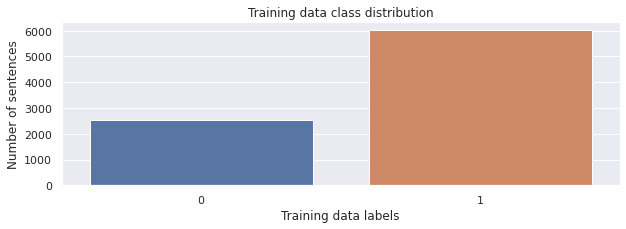

In [17]:
plt.figure(figsize=(10, 3))
sns.countplot(train_data['label'].values)
plt.xlabel("Training data labels")
plt.ylabel("Number of sentences")
plt.title("Training data class distribution")

Text(0.5, 1.0, 'Validation data class distribution')

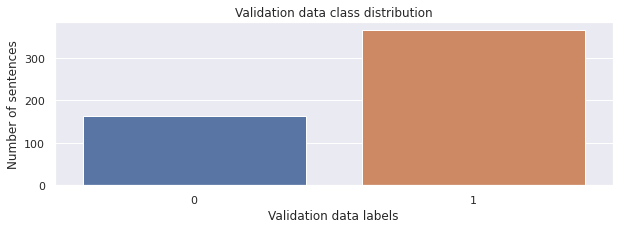

In [18]:
plt.figure(figsize=(10, 3))
sns.countplot(val_data['label'].values)
plt.xlabel("Validation data labels")
plt.ylabel("Number of sentences")
plt.title("Validation data class distribution")

### Check source of sentences

Text(0.5, 1.0, 'Source of sentence distribution')

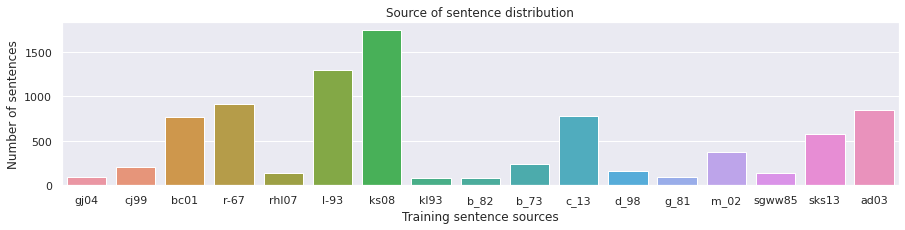

In [19]:
plt.figure(figsize=(15, 3))
sns.countplot(train_data['sentence_source'].values)
plt.xlabel("Training sentence sources")
plt.ylabel("Number of sentences")
plt.title("Source of sentence distribution")

Text(0.5, 1.0, 'Source of sentence distribution in Validation Dataset')

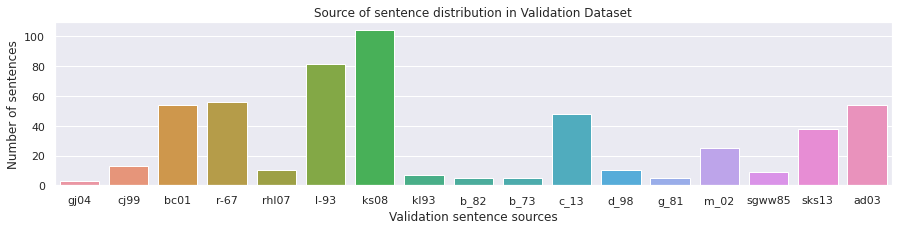

In [20]:
plt.figure(figsize=(15, 3))
sns.countplot(val_data['sentence_source'].values)
plt.xlabel("Validation sentence sources")
plt.ylabel("Number of sentences")
plt.title("Source of sentence distribution in Validation Dataset")

In [21]:
train_data.drop(columns=["sentence_source", "label_notes"], axis=1, inplace=True)
train_data.head()

,label,sentence
0,1,"Our friends won't buy this analysis, let alone..."
1,1,One more pseudo generalization and I'm giving up.
2,1,One more pseudo generalization or I'm giving up.
3,1,"The more we study verbs, the crazier they get."
4,1,Day by day the facts are getting murkier.


In [22]:
val_data.drop(columns=["sentence_source", "label_notes"], axis=1, inplace=True)
val_data.head()

,label,sentence
0,1,The sailors rode the breeze clear of the rocks.
1,1,The weights made the rope stretch over the pul...
2,1,The mechanical doll wriggled itself loose.
3,1,"If you had eaten more, you would want less."
4,0,"As you eat the most, you want the least."


In [23]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [24]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
# Maximum sequence length
sequence_lengths = []
for sent in train_data['sentence']:
    words = word_tokenize(sent)
    sequence_lengths.append(len(words))

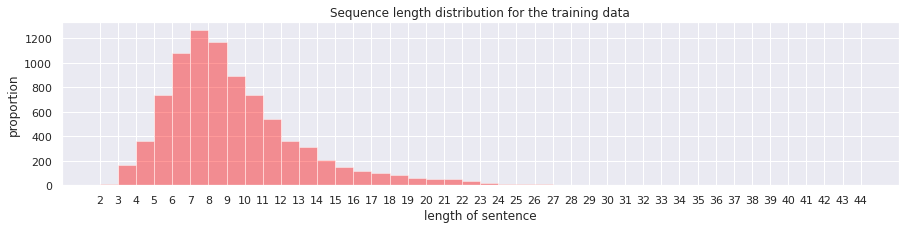

In [26]:
plt.figure(figsize=(15,3))
plt.hist(sequence_lengths, bins=range(min(sequence_lengths), max(sequence_lengths) + 1, 1), 
              alpha=0.4, color="red")

plt.xlabel("length of sentence")
plt.ylabel("proportion")
plt.title("Sequence length distribution for the training data")
_ = plt.xticks(range(min(sequence_lengths), max(sequence_lengths) + 1, 1))

### Model Preparation

In [27]:
MODEL_NAME = 'bert-base-uncased'
MODEL_PATH = 'bert_model.bin'

In [28]:
MAX_SEQ_LEN = 44
BATCH_SIZE = 8
OUTPUT_DIM = 1
EPOCHS = 3

In [29]:
# ipywidgets for progress bar
%pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [30]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
class ColaDataset:
    def __init__(self, sentences, labels):
        super().__init__()
        
        self.sentences = sentences
        self.labels = labels
        
        self.tokenizer = tokenizer
        self.max_len = MAX_SEQ_LEN
        
    def __len__(self):
        """Return the number of data points in the dataset"""
        return len(self.labels)
    
    def __getitem__(self, idx):
        """Returns the data based on the given index"""
        sentence = self.sentences[idx]
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
                    sentence,
                    add_special_tokens=True,
                    max_length=self.max_len,
                    return_token_type_ids=False,
                    pad_to_max_length=True,
                    return_attention_mask=True,
                    truncation=True,
                    return_tensors='pt')
        
        output_item = {
            "ids": encoding["input_ids"].flatten(),
            "mask": encoding["attention_mask"].flatten(),
            "targets": torch.tensor(label, dtype=torch.float)
        }
        
        return output_item

In [32]:
train_dataset = ColaDataset(
                sentences=train_data.sentence.values,
                labels=train_data.label.values)

val_dataset = ColaDataset(
                sentences=val_data.sentence.values,
                labels=val_data.label.values)

In [33]:
train_dataloader = DataLoader(
                    train_dataset,
                    batch_size=BATCH_SIZE,
                    shuffle=True)

val_dataloader = DataLoader(
                    val_dataset,
                    batch_size=BATCH_SIZE,
                    shuffle=True)

In [66]:
model = BertModel.from_pretrained("bert-base-uncased")

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs)
outputs.pooler_output.shape

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([1, 768])

In [67]:
class BERTModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.bert_dropout = nn.Dropout(0.5)
        self.out = nn.Linear(768, OUTPUT_DIM)
        
    def forward(self, ids, mask):
        bert_output = self.bert(ids, attention_mask=mask)
        dropout_output = self.bert_dropout(bert_output.pooler_output)
        output = self.out(dropout_output)
        return output

In [68]:
model = BERTModel()
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

In [69]:
model_parameters = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]

optimizer_parameters = [
    {
        "params":[
            p for n,p in model_parameters if not any(i in n for i in no_decay)
        ],
        "weight_decay": 0.001,
    },
    {
        "params":[
            p for n, p in model_parameters if any (i in n for i in no_decay)
        ],
        "weight_decay": 0.0
    }
]

In [70]:
(5//2*3)

6

In [71]:
optimizer = AdamW(optimizer_parameters, lr=3e-5)
num_training_steps = int(len(train_data)/BATCH_SIZE * EPOCHS)

scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=num_training_steps)

criterion = nn.BCEWithLogitsLoss().to(device)

In [77]:
def train(dataloader, model, optimizer, criterion, scheduler):
    model.train()
    epoch_loss = 0
    
    for batch in dataloader:
        ids = batch["ids"].to(device)
        masks = batch["mask"].to(device)
        targets = batch["targets"].to(device)
        optimizer.zero_grad()
        
        outputs = model(ids=ids, mask=masks)
        loss = criterion(outputs, targets.view(-1, 1))
        
        epoch_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    return epoch_loss/len(dataloader)

In [78]:
def evaluate(data_loader, model, criterion):
    model.eval()

    fin_outputs = []
    fin_targets = []
    epoch_loss = 0

    with torch.no_grad():
        for batch in data_loader:
            ids = batch["ids"].to(device)
            mask = batch["mask"].to(device)
            targets = batch["targets"].to(device)

            outputs = model(
                ids=ids,
                mask=mask
            )

            loss = criterion(outputs, targets.view(-1, 1))
            epoch_loss += loss.item()

            targets = targets.cpu().detach()
            fin_targets.extend(targets.numpy().tolist())

            outputs = torch.sigmoid(outputs).cpu().detach()
            fin_outputs.extend(outputs.numpy().tolist())
            
    outputs = np.array(fin_outputs) >= 0.5
    accuracy = metrics.accuracy_score(fin_targets, outputs)
    mat_cor = metrics.matthews_corrcoef(fin_targets, outputs)
    
    return epoch_loss / len(data_loader), accuracy, mat_cor

In [79]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [80]:
sample = next(iter(train_dataloader))
sample["ids"].shape, sample["mask"].shape, sample["targets"].shape

(torch.Size([8, 44]), torch.Size([8, 44]), torch.Size([8]))

In [82]:
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    start_time = time.time()

    train_loss = train(train_dataloader, model, optimizer, criterion, scheduler)
    val_loss, val_acc, val_mat_cor = evaluate(val_dataloader, model, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model.state_dict(), MODEL_PATH)
    
    print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
    print(f"\t Train Loss: {train_loss:.3f}")
    print(f"\t Valid Loss: {val_loss:.3f} | Valid Acc: {val_acc * 100:.2f} | Matthews Cor: {val_mat_cor:.3f}")

Epoch: 01 | Epoch Time: 1m 40s
	 Train Loss: 0.231
	 Valid Loss: 0.425 | Valid Acc: 84.06 | Matthews Cor: 0.610
Epoch: 02 | Epoch Time: 1m 40s
	 Train Loss: 0.094
	 Valid Loss: 0.512 | Valid Acc: 84.44 | Matthews Cor: 0.620
Epoch: 03 | Epoch Time: 1m 40s
	 Train Loss: 0.063
	 Valid Loss: 0.511 | Valid Acc: 84.44 | Matthews Cor: 0.620


In [103]:
def predict(sentence, model, device):
    encoded = tokenizer.encode_plus(
                sentence,
                max_length=MAX_SEQ_LEN,
                add_special_tokens=True,
                return_token_type_ids=False,
                pad_to_max_length=True,
                return_attention_mask=True,
                truncation=True,
                return_tensors='pt')
    
    input_ids = encoded["input_ids"].to(device)
    attention_mask = encoded["attention_mask"].to(device)
    model = model.to(device)
    
    output = model(input_ids, attention_mask)
    prediction_proba = torch.round(torch.sigmoid(output))
    if prediction_proba > 0.5:
        prediction = "Correct"
    else:
        prediction = "Incorrect"
    print(f"Given sentence: {sentence} is grammatically {prediction}")

In [104]:
predict("I think this sentence is correct", model, 'cpu')

Given sentence: I think this sentence is correct is grammatically Correct


In [105]:
predict("I are thinks that this may correct", model, 'cpu')

Given sentence: I are thinks that this may correct is grammatically Incorrect


In [106]:
predict("This is got to be a correct one", model, 'cpu')

Given sentence: This is got to be a correct one is grammatically Correct
